# Generating Random Bayesian Network

This notebook shows how to generate singly- and multi-connected Bayesian Belief Networks (BBNs). The algorithms are taken directly from [here](https://pdfs.semanticscholar.org/5273/2fb57129443592024b0e7e46c2a1ec36639c.pdf). When generating a BBN, you have to generate

* the structure, which is a directed acyclic graph (DAG), and
* the parameters, which are local probability models.

In this notebook, the parameters are assumed to take on the [Dirichlet-Multinomial](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution) distribution. If you are wondering, a singly-connected BBN is one when, ignoring the directions of the edges in the DAG, there is at most one path between any two nodes. A multi-connected BBN is one that is not singly-connected (it is defined by the negation of a singly-connected BBN). The BBNs generated using this approach gaurantees the distribution of the BBNs are uniformly distributed (look at the paper for proofs, details, and benefits of having this property). 

## Generate the structure

Here, we generate the DAGs of a singly- and multi-connected BBNs. Note that when we visualize the DAGs, we do so by converting it to an undirected graph only because the layout algorithm is more aesthetically pleasing.

In [1]:
import warnings
import networkx as nx
import numpy as np
import json
import matplotlib.pyplot as plt
from networkx.algorithms.dag import is_directed_acyclic_graph
from networkx.algorithms.shortest_paths.generic import shortest_path

np.random.seed(37)

def get_simple_ordered_tree(n):
    """
    Generates a simple-ordered tree. The tree is just a 
    directed acyclic graph of n nodes with the structure
    0 --> 1 --> .... --> n.
    """
    g = nx.DiGraph()
    
    for i in range(n):
        g.add_node(i)
    
    for i in range(n - 1):
        g.add_edges_from([(i, i+1, {})])
    return g

def convert_to_undirected_graph(g):
    """
    Converts a directed acyclic graph (DAG) to an undirected graph.
    We need to convert a DAG to an undirected one to use
    some API calls to operate over the undirected graph. For example,
    in checking for connectedness of a graph, the API has a method
    to check for connectedness of an undirected graph, but not a 
    DAG.
    """
    u = nx.Graph()
    for n in g.nodes:
        u.add_node(n)
    for e in g.edges:
        u.add_edges_from([(e[0], e[1], {})])
    return u

def is_connected(g):
    """
    Checks if a the directed acyclic graph is connected.
    """
    u = convert_to_undirected_graph(g)
    return nx.is_connected(u)

def get_random_node_pair(n):
    """
    Randomly generates a pair of nodes.
    """
    i = np.random.randint(0, n)
    j = i
    while j == i:
        j = np.random.randint(0, n)
    return i, j

def edge_exists(i, j, g):
    """
    Checks if the edge i --> j exists in the graph, g.
    """
    return j in list(g.successors(i))

def del_edge(i, j, g):
    """
    Deletes the edge i --> j in the graph, g. The edge is only
    deleted if this removal does NOT cause the graph to be
    disconnected.
    """
    if g.has_edge(i, j) is True:
        g.remove_edge(i, j)

        if is_connected(g) is False:
            g.add_edges_from([(i, j, {})])
        
def add_edge(i, j, g):
    """
    Adds an edge i --> j to the graph, g. The edge is only
    added if this addition does NOT cause the graph to have
    cycles.
    """
    g.add_edges_from([(i, j, {})])
    if is_directed_acyclic_graph(g) is False:
        g.remove_edge(i, j)
        
def find_predecessor(i, j, g):
    """
    Finds a predecessor, k, in the path between two nodes, i and j,
    in the graph, g. We assume g is connected, and there is a 
    path between i and j (ignoring the direction of the edges).
    We want to find a k, that is a parent of j, that is in
    the path between i and j. In some cases, we may not find
    such a k.
    """
    parents = list(g.predecessors(j))
    u = convert_to_undirected_graph(g)
    for pa in parents:
        try:
            path = shortest_path(u, pa, i)
            return pa
        except:
            pass
    return None
        
def generate_multi_connected_structure(n, max_iter=10):
    """
    Generates a multi-connected directed acyclic graph.
    """
    g = get_simple_ordered_tree(n)
    for it in range(max_iter):
        i, j = get_random_node_pair(n)
        if g.has_edge(i, j) is True:
            del_edge(i, j, g)
        else:
            add_edge(i, j, g)
    return g
    
def generate_singly_structure(n, max_iter=10):
    """
    Generates a singly-connected directed acyclic graph.
    """
    g = get_simple_ordered_tree(n)
    
    counter = 0
    for it in range(max_iter):
        i, j = get_random_node_pair(n)
        if g.has_edge(i, j) is True or g.has_edge(j, i) is True:
            pass
        else:
            p = np.random.random()
            k = find_predecessor(i, j, g)
            if k is not None:
                g.remove_edge(k, j)
                if p < 0.5:
                    g.add_edges_from([(j, i, {})])
                else:
                    g.add_edges_from([(i, j, {})])
                
                if is_connected(g) is False:
                    g.add_edges_from([(k, j, {})])
                
                    if p < 0.5:
                        g.remove_edge(j, i)
                    else:
                        g.remove_edge(i, j)
    return g

### Generate DAG for singly-connected BBN

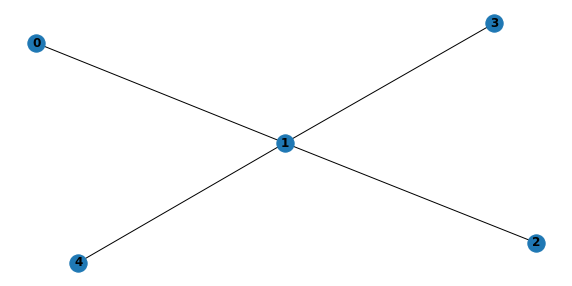

In [2]:
with warnings.catch_warnings(record=True):
    s = generate_singly_structure(5, 1000)
    plt.figure(figsize=(10, 5))
    plt.subplot(111)
    nx.draw(convert_to_undirected_graph(s), with_labels=True, font_weight='bold')

### Generate DAG for multi-connected BBN

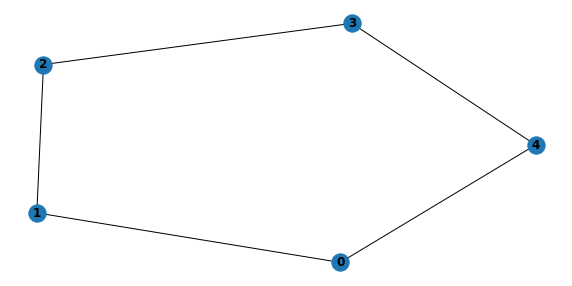

In [3]:
with warnings.catch_warnings(record=True):
    m = generate_multi_connected_structure(5, 10)
    plt.figure(figsize=(10, 5))
    plt.subplot(111)
    nx.draw(convert_to_undirected_graph(m), with_labels=True, font_weight='bold')

## Generate the parameters

Here, we generate parameters for the BBNs. 

In [4]:
from scipy.stats import dirichlet, multinomial

def generate_num_values(n, max_values=2):
    """
    For each node, i, in the nodes, n, determine the number of values
    the node (or equivalently, variable) has. Every node/variable in a
    Bayesian Network should have 2 or more values. This generates
    the number of values each variable will have. Each number will be
    sampled uniformly.
    """
    return np.array([max(np.random.randint(0, max_values) + 1, 2) for _ in range(n)])

def generate_alphas(n, max_alpha=10):
    """
    Generate random number for the alpha's (the hyperparameters).
    Each number will be in the range [1, max_alpha]. Each number will
    be sampled uniformly.
    """
    return [np.random.randint(1, max_alpha + 1) for i in range(n)]

def sample_dirichlet(n, max_alpha=10):
    """
    Samples from the Dirichlet distribution to a produce
    a probability vector of length n. The sum of each probability
    in the probability vector should sum to 1.
    """
    return np.array(dirichlet.rvs(generate_alphas(n, max_alpha))[0])

def get_num_parent_instantiations(parents, num_values):
    num_pa_instantiations = 1
    for pa in parents:
        num_pa_values = num_values[pa]
        num_pa_instantiations *= num_pa_values
    return num_pa_instantiations

def generate_dirichlet_parameters(i, parents, num_values, max_alpha=10):
    """
    Randomly and uniformly generate parameters for a node i. A matrix
    of parameters will be returned. The matrix will represent the 
    condtional probability table of the node i. The matrix will have
    the dimensions m (rows) by n (columns), m x n, where m is the
    product of the domain sizes of the parents, and n is the domain
    size of the node. The domain size is just the number of values
    that a node (variable) has, which should always be greater than
    or equal to 2.
    """
    num_pa_instantiations = get_num_parent_instantiations(parents, num_values)
    
    n = num_values[i]
    cpt = []
    for pa_instantiation in range(num_pa_instantiations):
        probs = sample_dirichlet(n, max_alpha)
        cpt.append(probs)
    return np.array(cpt)

def generate_parameters(g, max_values=2, max_alpha=10):
    """
    Generates parameters for each node in the graph, g.
    A dictionary indexed by the node's id will give its
    (sampled) parameters and its parents. 
    """
    num_nodes = len(list(g.nodes))
    num_values = generate_num_values(num_nodes, max_values)
    g_params = {}
    for i in g.nodes:
        parents = list(g.predecessors(i))
        params = generate_dirichlet_parameters(i, parents, num_values, max_alpha)
        g_params[i] = {
            'parents': parents,
            'params': params,
            'shape': [get_num_parent_instantiations(parents, num_values), num_values[i]]
        }
    return g_params

### Generate parameters for singly-connected BBN

In [5]:
s_params = generate_parameters(s)
print(s_params)

{0: {'parents': [], 'params': array([[0.74174228, 0.25825772]]), 'shape': [1, 2]}, 1: {'parents': [2, 3, 0, 4], 'params': array([[0.50086958, 0.49913042],
       [0.02647713, 0.97352287],
       [0.42054028, 0.57945972],
       [0.85369846, 0.14630154],
       [0.22294388, 0.77705612],
       [0.36867171, 0.63132829],
       [0.86317661, 0.13682339],
       [0.12457256, 0.87542744],
       [0.50873009, 0.49126991],
       [0.82929381, 0.17070619],
       [0.67980646, 0.32019354],
       [0.86189091, 0.13810909],
       [0.8995967 , 0.1004033 ],
       [0.53483643, 0.46516357],
       [0.52939964, 0.47060036],
       [0.83144941, 0.16855059]]), 'shape': [16, 2]}, 2: {'parents': [], 'params': array([[0.42051707, 0.57948293]]), 'shape': [1, 2]}, 3: {'parents': [], 'params': array([[0.80468897, 0.19531103]]), 'shape': [1, 2]}, 4: {'parents': [], 'params': array([[0.67431296, 0.32568704]]), 'shape': [1, 2]}}


### Generate parameters for muti-connected BBN

In [6]:
m_params = generate_parameters(m)
print(m_params)

{0: {'parents': [], 'params': array([[0.27733808, 0.72266192]]), 'shape': [1, 2]}, 1: {'parents': [0], 'params': array([[0.50940174, 0.49059826],
       [0.99785858, 0.00214142]]), 'shape': [2, 2]}, 2: {'parents': [1, 3], 'params': array([[0.33727417, 0.66272583],
       [0.79651078, 0.20348922],
       [0.40652547, 0.59347453],
       [0.88763038, 0.11236962]]), 'shape': [4, 2]}, 3: {'parents': [], 'params': array([[0.85069727, 0.14930273]]), 'shape': [1, 2]}, 4: {'parents': [3, 0], 'params': array([[0.68777784, 0.31222216],
       [0.4609832 , 0.5390168 ],
       [0.46319254, 0.53680746],
       [0.10677866, 0.89322134]]), 'shape': [4, 2]}}


## Persist (save) the Bayesian Belief Network

Here, we show how to save the BBN (the DAG and parameters). Note that we save it to a JSON file format. There are simply too many formats for BBNs, but the JSON format here has all the information you need to convert it to any other format.

In [7]:
def to_json(g, params, pretty=True):
    to_int_arr = lambda arr: [int(item) for item in arr]
    j = {}
    
    j['nodes'] = list(g.nodes)
    j['edges'] = [{'pa': e[0], 'ch': e[1]} for e in g.edges]
    j['parameters'] = [{'node': k, 
                        'params': list(v['params'].flatten()), 
                        'shape': to_int_arr(v['shape'])} 
                       for k, v in params.items()]
    if pretty:
        return json.dumps(j, indent=2, sort_keys=False)
    return json.dumps(j)

### Persist singly-connected BBN

In [8]:
s_json = to_json(s, s_params)
print(s_json)
with open('./output/singly-connected.json', 'w') as fhandle:
    fhandle.write(to_json(s, s_params, pretty=True))

{
  "nodes": [
    0,
    1,
    2,
    3,
    4
  ],
  "edges": [
    {
      "pa": 0,
      "ch": 1
    },
    {
      "pa": 2,
      "ch": 1
    },
    {
      "pa": 3,
      "ch": 1
    },
    {
      "pa": 4,
      "ch": 1
    }
  ],
  "parameters": [
    {
      "node": 0,
      "params": [
        0.7417422803682197,
        0.25825771963178046
      ],
      "shape": [
        1,
        2
      ]
    },
    {
      "node": 1,
      "params": [
        0.5008695756264835,
        0.4991304243735164,
        0.026477131905188734,
        0.9735228680948113,
        0.42054028327937387,
        0.579459716720626,
        0.8536984622587769,
        0.14630153774122318,
        0.22294387680535926,
        0.7770561231946408,
        0.3686717093409431,
        0.6313282906590567,
        0.8631766076552874,
        0.13682339234471266,
        0.1245725606108167,
        0.8754274393891833,
        0.5087300903407761,
        0.49126990965922374,
        0.8292938143560679,
     

### Persist multi-connected BBN

In [9]:
m_json = to_json(m, m_params)
print(m_json)
with open('./output/multi-connected.json', 'w') as fhandle:
    fhandle.write(to_json(m, m_params, pretty=True))

{
  "nodes": [
    0,
    1,
    2,
    3,
    4
  ],
  "edges": [
    {
      "pa": 0,
      "ch": 1
    },
    {
      "pa": 0,
      "ch": 4
    },
    {
      "pa": 1,
      "ch": 2
    },
    {
      "pa": 3,
      "ch": 4
    },
    {
      "pa": 3,
      "ch": 2
    }
  ],
  "parameters": [
    {
      "node": 0,
      "params": [
        0.2773380778096063,
        0.7226619221903937
      ],
      "shape": [
        1,
        2
      ]
    },
    {
      "node": 1,
      "params": [
        0.5094017382812316,
        0.4905982617187683,
        0.9978585783502765,
        0.002141421649723624
      ],
      "shape": [
        2,
        2
      ]
    },
    {
      "node": 2,
      "params": [
        0.3372741656699353,
        0.6627258343300647,
        0.7965107759562755,
        0.20348922404372444,
        0.40652547264228284,
        0.5934745273577172,
        0.8876303836604758,
        0.11236961633952422
      ],
      "shape": [
        4,
        2
      ]
    }

## All-in-one (AIO) example

Here's a simple AIO example of generating a singly-connected BBN and its corresponding JSON.

In [10]:
g = generate_singly_structure(5, 1000)
p = generate_parameters(g)
j = to_json(g, p)